**High-Mountain Asia climate analysis based on gridded observations**

**Katmandhu course, October, 2022**

Topography, temperature

**1. Environment**

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import os
from tqdm import tqdm

In [2]:
# Where are the data files?
path="/Users/mmenegoz/cours/nepal/data/" # Put your own path to the data !

In [3]:
# Domain study: HMA
lon1=60;lon2=110
lat1=25;lat2=45

**2. Open temperature data file (CRU)**

**or any other data file (e.g. IPSL model)!!!**

In [41]:
# CRU dataset (https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/cruts.2205201912.v4.06/tmp/cru_ts4.06.1901.2021.tmp.dat.nc.gz)
# https://www.nature.com/articles/s41597-020-0453-3
# Here we download only a part of the file
file='HMA_cru_ts4.06.1901.2021.tmp.dat.nc'
ds = xr.open_dataset(os.path.join(path,file))
ds # To print the header of the dataset

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 100, time: 1452)
Coordinates:
  * lat      (lat) float32 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2021-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.06 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2205201912. Data generated from:tmp.2204291209.dtb
    history:      Wed Oct 19 02:06:39 2022: ncks -O -v tmp HMA_cru_ts4.06.190...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...

**3. Extracting regional data and computing seasonal means**

In [5]:
# Extracting the data over HMA
longitudes=slice(lon1,lon2)
latitudes=slice(lat1,lat2)
temp_HMA=ds.sel(lat=latitudes,lon=longitudes)
temp_HMA # To print the header of the HMA dataset

<xarray.Dataset>
Dimensions:  (lat: 40, lon: 100, time: 1452)
Coordinates:
  * lat      (lat) float32 25.25 25.75 26.25 26.75 ... 43.25 43.75 44.25 44.75
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2021-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.06 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2205201912. Data generated from:tmp.2204291209.dtb
    history:      Wed Oct 19 02:06:39 2022: ncks -O -v tmp HMA_cru_ts4.06.190...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...

In [6]:
# define a function to compute seasonal mean
# Taking into account the differet number of days per months
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

**Below, you might need to change the name of the variable depending on the data that you use!**

**Also, be careful to the unit of the variable!**

In [7]:
# Computing seasonal mean and ordering properly the seasons
seasonal_mean=season_mean(temp_HMA.tmp).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

In [8]:
# Levels of temperature for the plot
levels=plot.arange(-34,34,2)

/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_pro

i=0
ax=GeoAxesSubplot(index=(0, 0), number=1, backend='cartopy')
i=1
ax=GeoAxesSubplot(index=(1, 1), number=2, backend='cartopy')
i=2
ax=GeoAxesSubplot(index=(2, 2), number=3, backend='cartopy')
i=3
ax=GeoAxesSubplot(index=(3, 3), number=4, backend='cartopy')


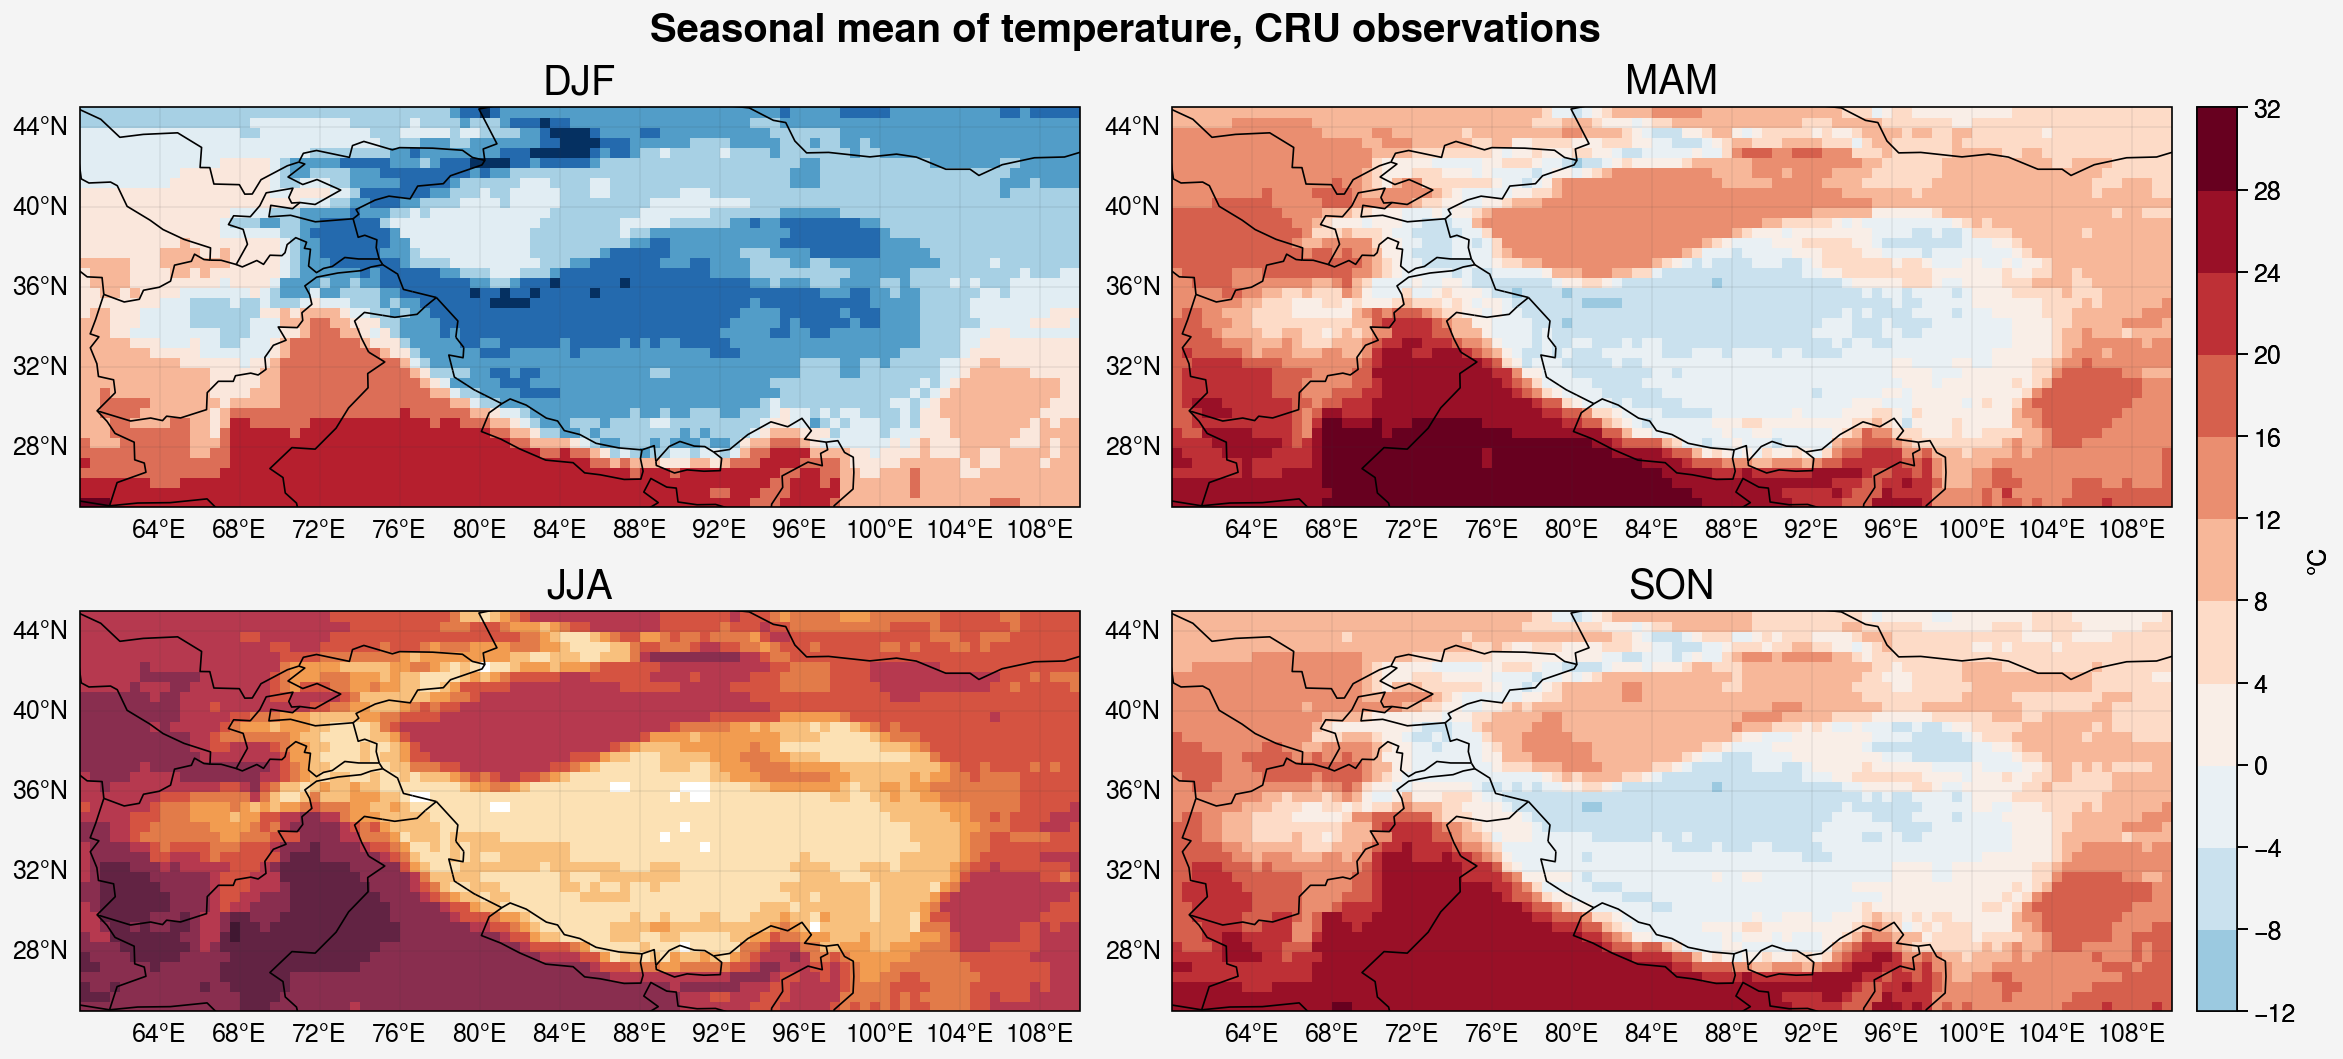

In [9]:
# Producing the map of the seasonal mean, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        temp_HMA.lon,temp_HMA.lat,
        seasonal_mean[i,:,:]#,
        #levels=levels,
        #cmap='coolwarm'
    )
    ax.format(title=seasonal_mean.season.data[i],large='20px')
    
f.colorbar(m, label= '°C')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=True, ocean=False, oceancolor='gray3', borders=True,
    suptitle="Seasonal mean of temperature, CRU observations",
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)

**4. Trends**

Choose the period that you want!

Be careful to the consistency between the period that you define and the period available in the dataset!

In [10]:
# Period over which computing the trends
date1="1901-01"; date2="2021-12"
date3="2022-12" # One year after date2
dates=pd.date_range(start=date1, end=date3, freq='Y')
dates.year

Index([1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       ...
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype='int32', length=121)

**Again, below, check the name of the variable!**

In [11]:
# Extract seasonal timeseries
Temp=temp_HMA.tmp.sel(time=slice(date1,date2))

**4.1 Check the trend and its level of significance in the location of your choice**

In [12]:
# location study
lon_loc=87; lat_loc=28 # Everest location!!!
#lon_loc=84; lat_loc=28
#lon_loc2=72; lat_loc2=32

In [13]:
# Extraction of the data at the point
temp_loc=Temp.sel(lon=lon_loc, lat=lat_loc, method="nearest")
#temp_loc2=Temp.sel(lon=lon_loc2, lat=lat_loc2, method="nearest")

In [14]:
# Creating an empty array with the seasonal data
seasonal_T_loc=np.empty(shape=(int(temp_loc.shape[0]/12),4), dtype=float)
seasonal_T_loc.shape

(121, 4)

In [15]:
# Seasonal spatial data
seasonal_T_loc [:,0] = temp_loc.where(Temp['time.season'] == 'DJF').groupby('time.year').mean(dim='time')
seasonal_T_loc [:,1] = temp_loc.where(Temp['time.season'] == 'MAM').groupby('time.year').mean(dim='time')
seasonal_T_loc [:,2] = temp_loc.where(Temp['time.season'] == 'JJA').groupby('time.year').mean(dim='time')
seasonal_T_loc [:,3] = temp_loc.where(Temp['time.season'] == 'SON').groupby('time.year').mean(dim='time')

In [16]:
# Computing trends
slope_T_loc=np.full(seasonal_T_loc.shape[1:4],np.nan)
pvalue_T_loc=np.full(seasonal_T_loc.shape[1:4],np.nan)
intercept_T_loc=np.full(seasonal_T_loc.shape[1:4],np.nan)
for season in range(4):
    linregress_T_loc = stats.linregress(range(seasonal_T_loc.shape[0]-1), seasonal_T_loc[1:,season])
    slope_T_loc[season] = linregress_T_loc.slope
    intercept_T_loc[season] = linregress_T_loc.intercept
    pvalue_T_loc[season] = linregress_T_loc.pvalue

In [17]:
seasonal_T_loc.shape

(121, 4)

In [18]:
index=np.arange(0,dates.shape[0])
index.shape

(121,)

In [19]:
pvalue_T_loc

array([1.03026387e-13, 9.57249977e-06, 4.25665274e-07, 6.85767836e-13])

i=0
ax=CartesianAxesSubplot(index=(0, 0), number=1)
i=1
ax=CartesianAxesSubplot(index=(1, 1), number=2)
i=2
ax=CartesianAxesSubplot(index=(2, 2), number=3)
i=3
ax=CartesianAxesSubplot(index=(3, 3), number=4)


/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1404960625.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=f"{seasonal_mean.season.data[i]} trend={slope_T_loc[i]*10:.2f}°C.decade-1; pvalue={pvalue_T_loc[i]:.2g}",large='10px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1404960625.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=f"{seasonal_mean.season.data[i]} trend={slope_T_loc[i]*10:.2f}°C.decade-1; pvalue={pvalue_T_loc[i]:.2g}",large='10px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1404960625.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=f"{seasonal_mean.season.data[i]} trend={slope_T_loc[i]*10:.2f}°C.decade-1; pvalue={pvalue_T_loc[i]:.2g}",large='10px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1404960625.py:12: ProplotW

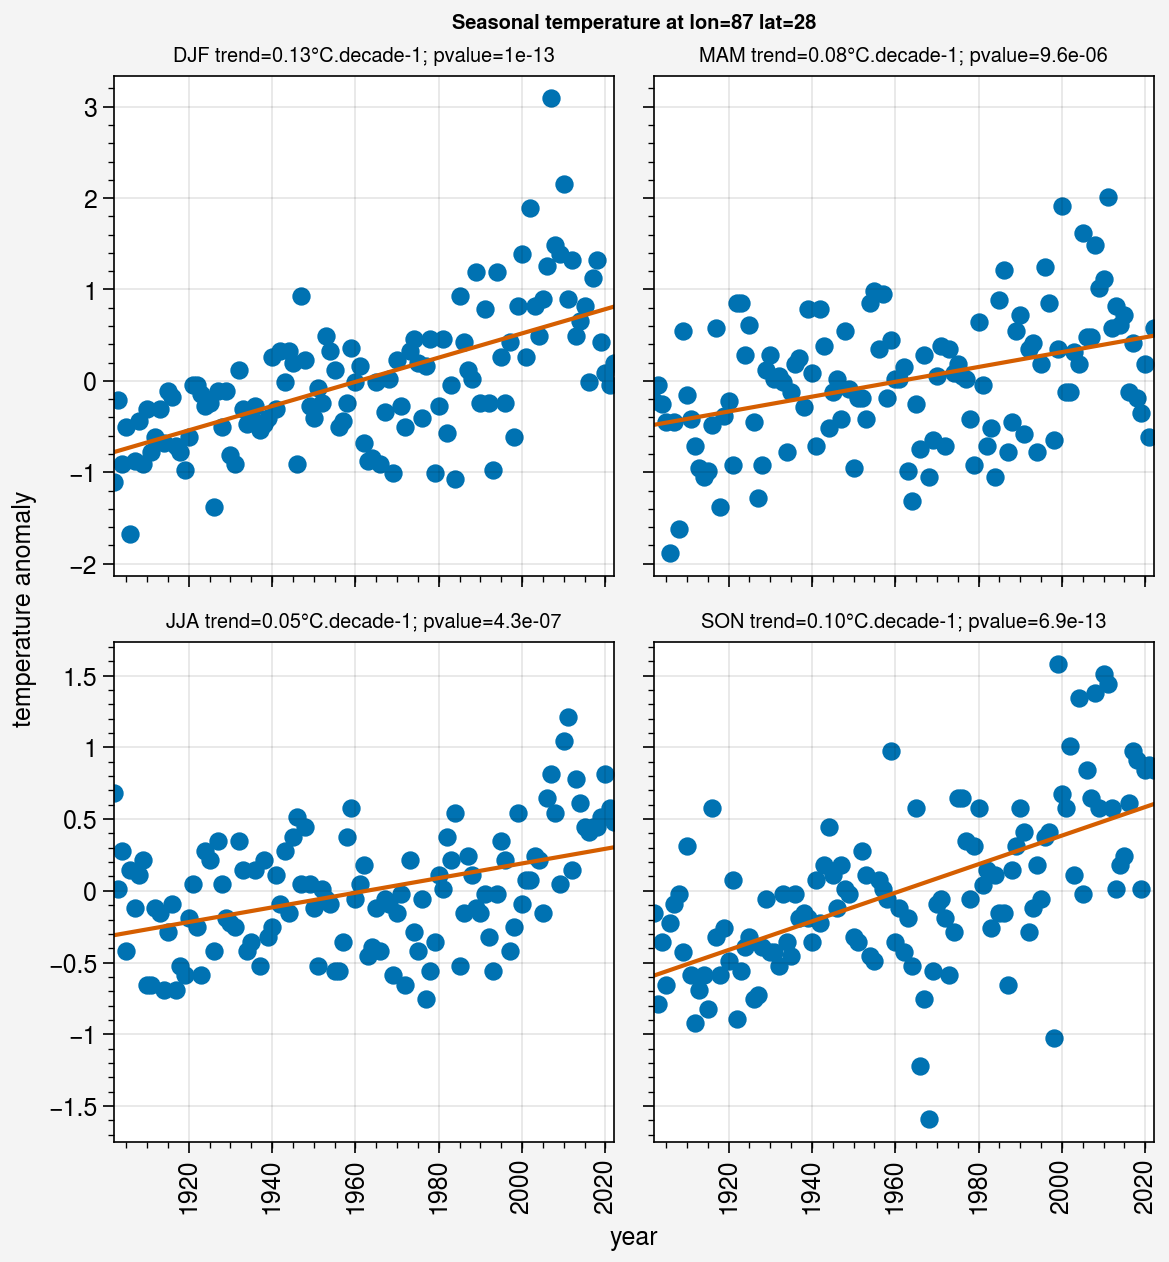

In [20]:
#Plotting temperature timeseries
f, axs = plot.subplots(ncols=2, nrows=2)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    if pvalue_T_loc[i]<0.05:
        signif='solid'
    else:
        signif='dashed'
    m = ax.scatter(dates,seasonal_T_loc[:,i]-np.mean(seasonal_T_loc[:,i]))
    m = ax.plot(dates,intercept_T_loc[i]+slope_T_loc[i]*index-np.mean(seasonal_T_loc[:,i]),linestyle=signif)
    ax.format(title=f"{seasonal_mean.season.data[i]} trend={slope_T_loc[i]*10:.2f}°C.decade-1; pvalue={pvalue_T_loc[i]:.2g}",large='10px')
    #ax.format(title=seasonal_mean.season.data[i]+' trend='+str(round(slope_T_loc[i]*10,2))+'°C.decade-1; '+'pvalue='+str(round(pvalue_T_loc[i],3)),large='10px')

axs.format(
    suptitle='Seasonal temperature at lon='+str(lon_loc)+' lat='+str(lat_loc),
    xlabel='year',
    ylabel='temperature anomaly'
)

**4.2. HMA trend maps**

In [21]:
# Getting the total number of years
int(Temp.shape[0]/12)

121

In [22]:
# Creating an empty array with the total seasonal data
seasonal_T=np.empty(shape=(int(Temp.shape[0]/12),4,Temp.shape[1],Temp.shape[2]), dtype=float)
seasonal_T.shape

(121, 4, 40, 100)

In [23]:
Temp.where(Temp['time.season'] == 'DJF').groupby('time.year').mean(dim='time').shape

(121, 40, 100)

In [24]:
# Seasonal spatial data
seasonal_T [:,0,:,:] = Temp.where(Temp['time.season'] == 'DJF').groupby('time.year').mean(dim='time')
seasonal_T [:,1,:,:] = Temp.where(Temp['time.season'] == 'MAM').groupby('time.year').mean(dim='time')
seasonal_T [:,2,:,:] = Temp.where(Temp['time.season'] == 'JJA').groupby('time.year').mean(dim='time')
seasonal_T [:,3,:,:] = Temp.where(Temp['time.season'] == 'SON').groupby('time.year').mean(dim='time')

In [25]:
seasonal_T.shape[3]

100

In [40]:
# Computing trends
slope_T=np.full(seasonal_T.shape[1:4],np.nan)
pvalue_T=np.full(seasonal_T.shape[1:4],np.nan)

for lon in tqdm(range(seasonal_T.shape[3])):
    for lat in range(seasonal_T.shape[2]):
        for season in range(4):
            linregress_T = stats.linregress(range(seasonal_T.shape[0]-1), seasonal_T[1:,season,lat,lon])
            slope_T[season][lat][lon] = linregress_T.slope
            pvalue_T[season][lat][lon] = linregress_T.pvalue

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


In [27]:
# Masking non-significative signals
signif=np.where(pvalue_T<0.05,True,False)

In [28]:
# Levels of temperature for the plot
levels=plot.arange(-0.3,0.3,0.05)
factor=10 # degree per decade

/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/usr/local/Caskroom/mambaforge/base/envs/HMA_env_2023/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_pro

i=0
ax=GeoAxesSubplot(index=(0, 0), number=1, backend='cartopy')
i=1
ax=GeoAxesSubplot(index=(1, 1), number=2, backend='cartopy')
i=2
ax=GeoAxesSubplot(index=(2, 2), number=3, backend='cartopy')
i=3
ax=GeoAxesSubplot(index=(3, 3), number=4, backend='cartopy')


/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1671443011.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='20px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1671443011.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='20px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1671443011.py:12: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='20px')
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1671443011.py:22: ProplotWarning: rc setting 'geogrid.linewidth' was renamed to 'grid.linewidth' in version 0.6.
  axs.format(
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/1671443011.py:22: ProplotWarning: rc setting 'geogrid.color' w

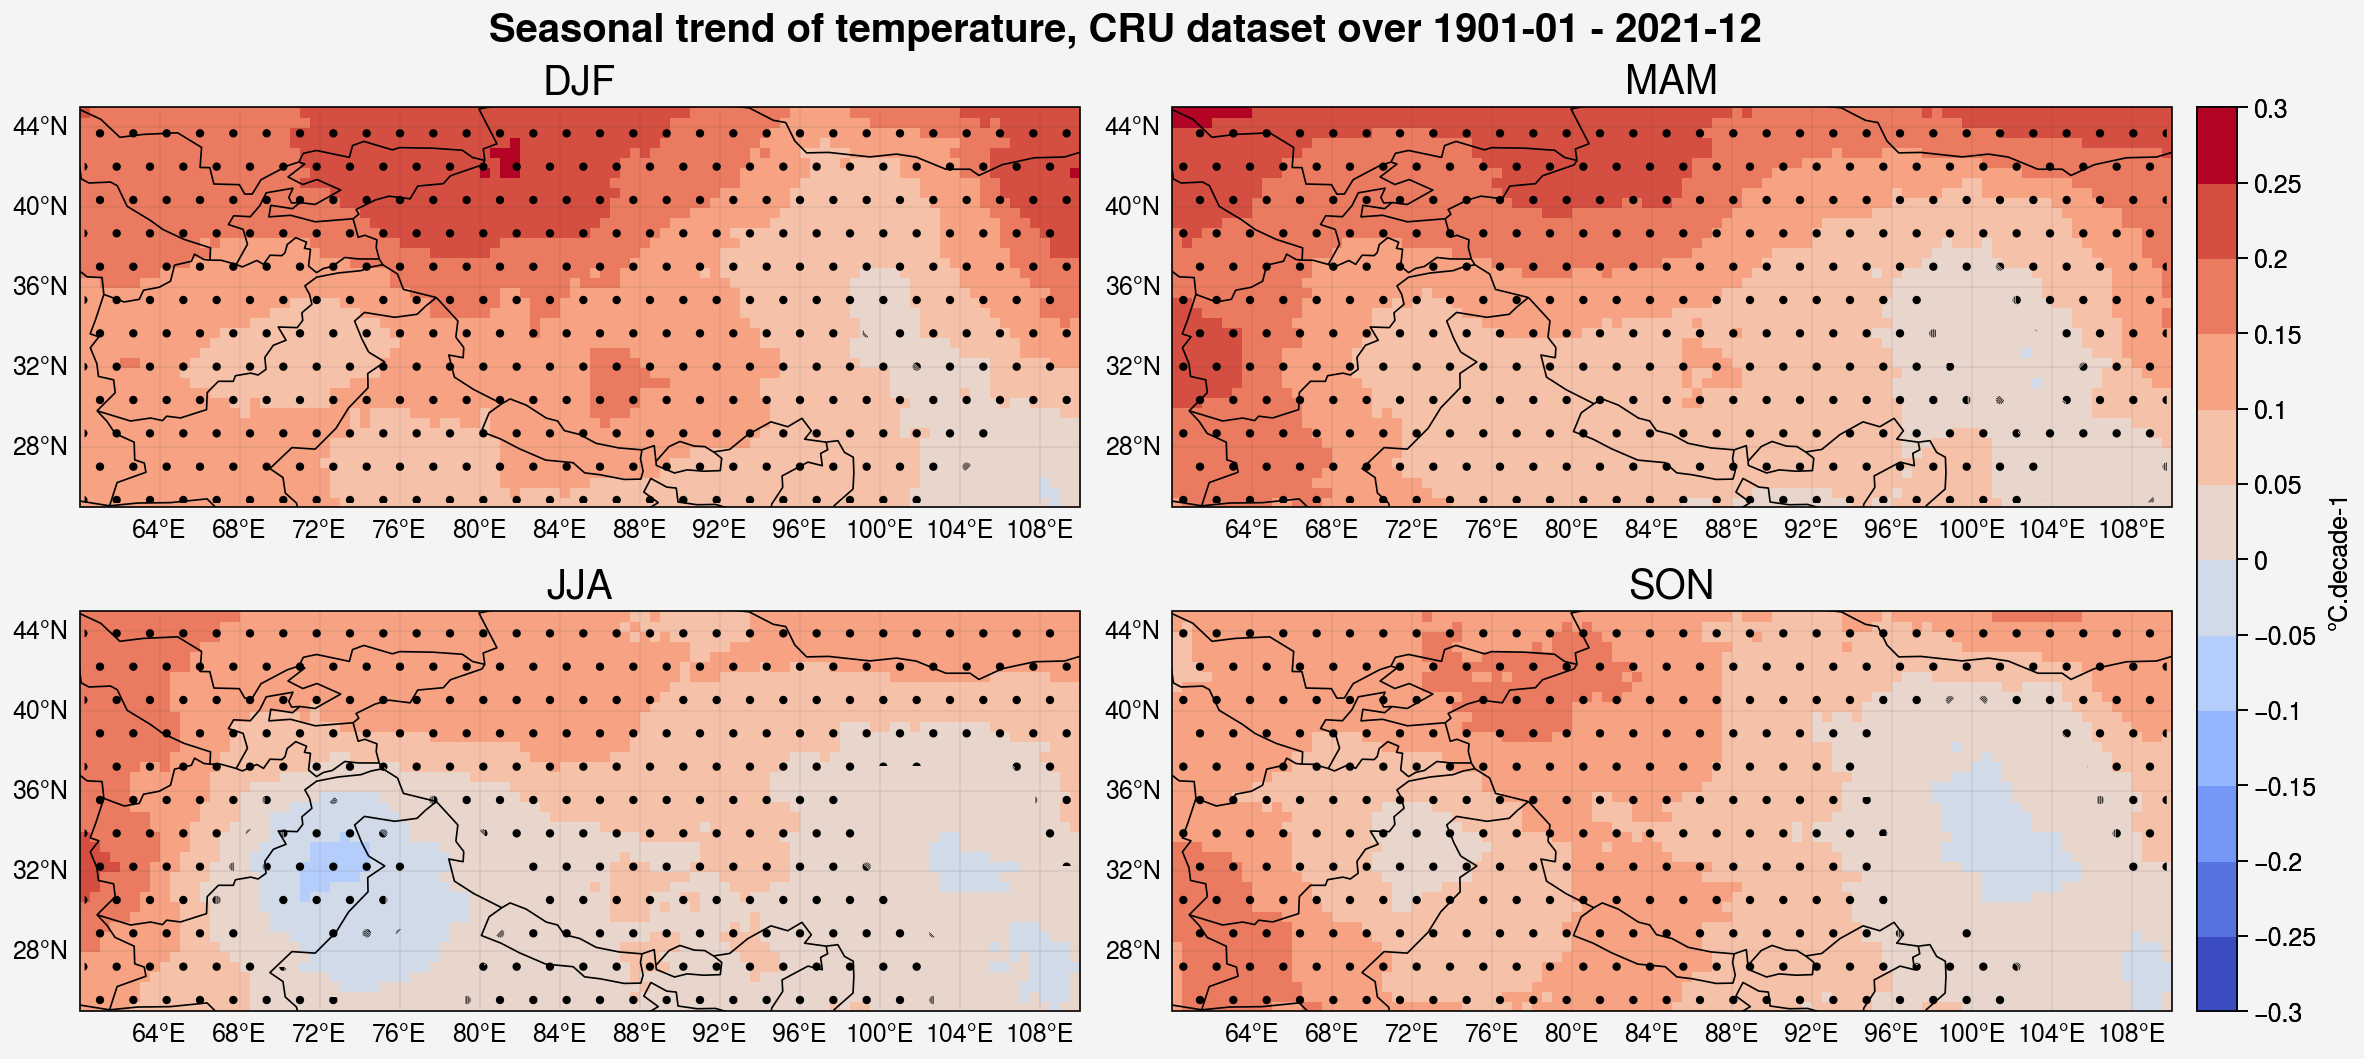

In [29]:
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        temp_HMA.lon,temp_HMA.lat,
        slope_T[i,:,:]*factor,
        levels=levels,
        cmap='coolwarm'
    )
    ax.format(title=seasonal_mean.season.data[i],large='20px')
    
    p = ax.contourf(
    temp_HMA.lon,temp_HMA.lat,
    signif[i,:,:],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= '°C.decade-1')

axs.format(
    geogridlinewidth=0.1, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=False, oceancolor='gray3', borders=True,
    suptitle="Seasonal trend of temperature, CRU dataset over "+date1+" - "+date2,
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)

**Now, you can invent your own analysis, e.g:**
* Computing trends where you want and over any period.
* Computing trends as a function of the elevation using the topography in the file below.
* Etc...


In [30]:
# Topography at 0.25° (http://research.jisao.washington.edu/data_sets/elevation/)
# -> 0.25-degree latitude-longitude resolution elevation (TBASE)
#file_topo="elev.0.25-deg.nc"
file_topo="GMTED_2023/GMTED2010_15n060_0250deg.nc"
ds_topo = xr.open_dataset(os.path.join(path,file_topo))
ds_topo # ds_topo as dataset

<xarray.Dataset>
Dimensions:           (latitude: 720, longitude: 1440, nbounds: 2)
Coordinates:
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nbounds           (nbounds) int16 0 1
Data variables:
    latitude_bounds   (latitude, nbounds) float32 ...
    longitude_bounds  (longitude, nbounds) float32 ...
    elevation         (latitude, longitude) int16 ...
    elevation_stddev  (latitude, longitude) int16 ...
    elevation_max     (latitude, longitude) int16 ...
    elevation_min     (latitude, longitude) int16 ...
Attributes: (12/13)
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    Title:                      GMTED2010 elevation data regridded at 0.250 d...
    resolution_degrees:         0.25
    resolution_summing_factor:  60
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    ...                         ...
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    creation_date:              2022-03-08

In [31]:
# We replace lon and lat coordinates with latitude and longitude to allow an easy managing of ds_topo with xarray:
#ds_topo_bis=ds_topo.assign_coords(lon=ds_topo.longitude,lat=ds_topo.latitude)
#ds_topo_bis=ds_topo.swap_dims({"nlat": "latitude","nlon": "longitude"})
#ds_topo_bis

In [32]:
# Extracting the data over HMA
# be careful to reversed latitudes in the original file
#topo_HMA=ds_topo.isel(time=0).sel(lon=slice(lon1,lon2),lat=slice(lat2,lat1))
topo_HMA=ds_topo.sel(longitude=slice(lon1,lon2),latitude=slice(lat1,lat2))

In [33]:
topo_HMA

<xarray.Dataset>
Dimensions:           (latitude: 80, longitude: 200, nbounds: 2)
Coordinates:
  * latitude          (latitude) float32 25.12 25.38 25.62 ... 44.38 44.62 44.88
  * longitude         (longitude) float32 60.12 60.38 60.62 ... 109.6 109.9
  * nbounds           (nbounds) int16 0 1
Data variables:
    latitude_bounds   (latitude, nbounds) float32 ...
    longitude_bounds  (longitude, nbounds) float32 ...
    elevation         (latitude, longitude) int16 ...
    elevation_stddev  (latitude, longitude) int16 ...
    elevation_max     (latitude, longitude) int16 ...
    elevation_min     (latitude, longitude) int16 ...
Attributes: (12/13)
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    Title:                      GMTED2010 elevation data regridded at 0.250 d...
    resolution_degrees:         0.25
    resolution_summing_factor:  60
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    ...                         ...
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    creation_date:              2022-03-08

/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/3274268623.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m=ax.pcolormesh(topo_HMA.longitude,topo_HMA.latitude,topo_HMA.elevation)


Text(0.5, 1.0, 'Topography GMTED with a 0.25° resolution')

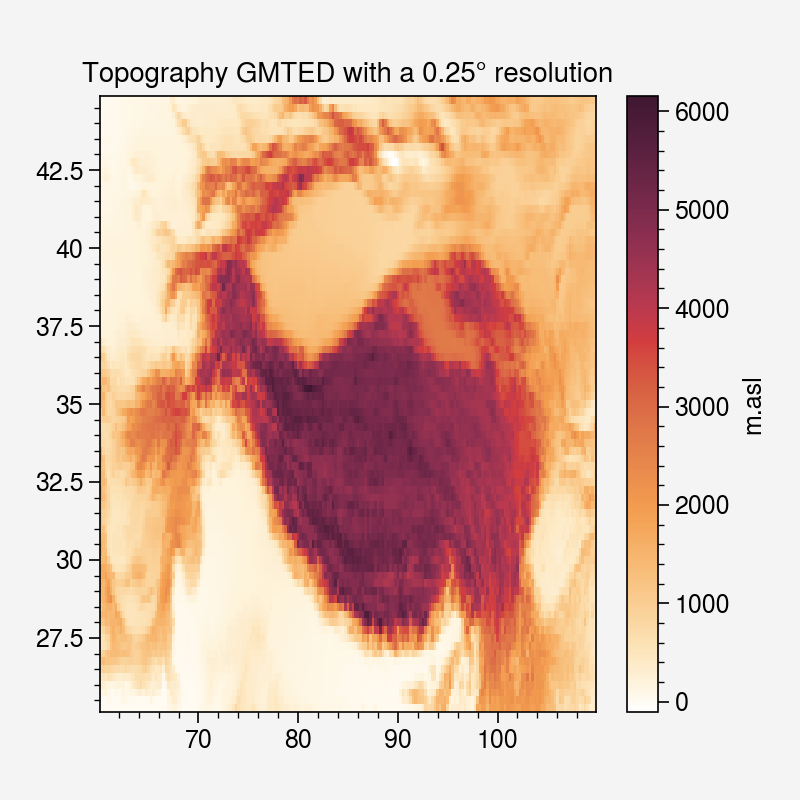

In [34]:
fig, ax = plt.subplots()
m=ax.pcolormesh(topo_HMA.longitude,topo_HMA.latitude,topo_HMA.elevation)
fig.colorbar(m,label= 'm.asl')
#ax.set_title('Topography TBASE with a 0.25° resolution')
ax.set_title('Topography GMTED with a 0.25° resolution')

In [35]:
# Interpolation of the topography on the CRU grid
ds_topo_HMA_out=topo_HMA.interp(latitude=temp_HMA.lat,longitude=temp_HMA.lon)

/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/45248775.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m=ax.pcolormesh(ds_topo_HMA_out.longitude,ds_topo_HMA_out.latitude,ds_topo_HMA_out.elevation)


Text(0.5, 1.0, 'Topography GMTED interpolated on a 0.5° resolution')

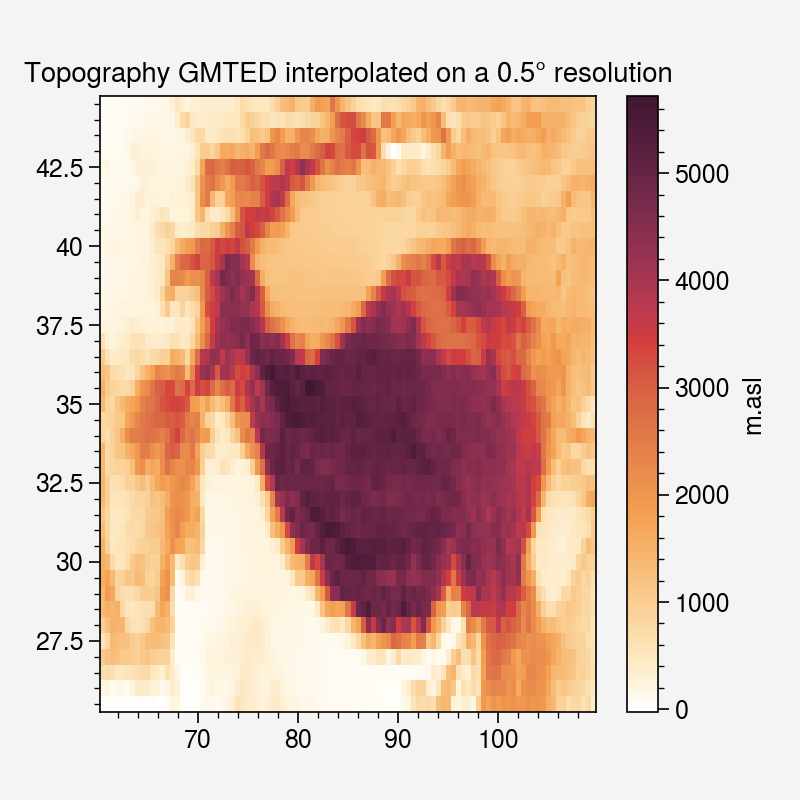

In [36]:
fig, ax = plt.subplots()
m=ax.pcolormesh(ds_topo_HMA_out.longitude,ds_topo_HMA_out.latitude,ds_topo_HMA_out.elevation)
fig.colorbar(m,label= 'm.asl')
ax.set_title('Topography GMTED interpolated on a 0.5° resolution')

In [37]:
# Levels of temperature for the plot
#levels=np.arange(-0.5,0.5,0.05)
factor_trend=10 # degree per decade
bins=100
levels=np.logspace(0,1,25)

In [38]:
# We keep only the elevation area > limit m.asl
limit=1000
topo_high=ds_topo_HMA_out.elevation.where(ds_topo_HMA_out.elevation > limit)
trends_high=np.zeros(slope_T.shape)
for i in np.arange(4):
    trends_high[i,:,:]=np.where(ds_topo_HMA_out.elevation > limit,slope_T[i,:,:],np.nan)

i=0
ax=CartesianAxesSubplot(index=(0, 0), number=1)
i=1
ax=CartesianAxesSubplot(index=(1, 1), number=2)
i=2
ax=CartesianAxesSubplot(index=(2, 2), number=3)
i=3
ax=CartesianAxesSubplot(index=(3, 3), number=4)


/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/32905718.py:10: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='15px',xlim=(-0.05,0.25))
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/32905718.py:10: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='15px',xlim=(-0.05,0.25))
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/32905718.py:10: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='15px',xlim=(-0.05,0.25))
/var/folders/4b/vxx29sys075bqrll6chl6wxc0006yn/T/ipykernel_25133/32905718.py:10: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  ax.format(title=seasonal_mean.season.data[i],large='15px',xlim=(-0.05,0.25))
/var/folders/4b/vxx29sys075b

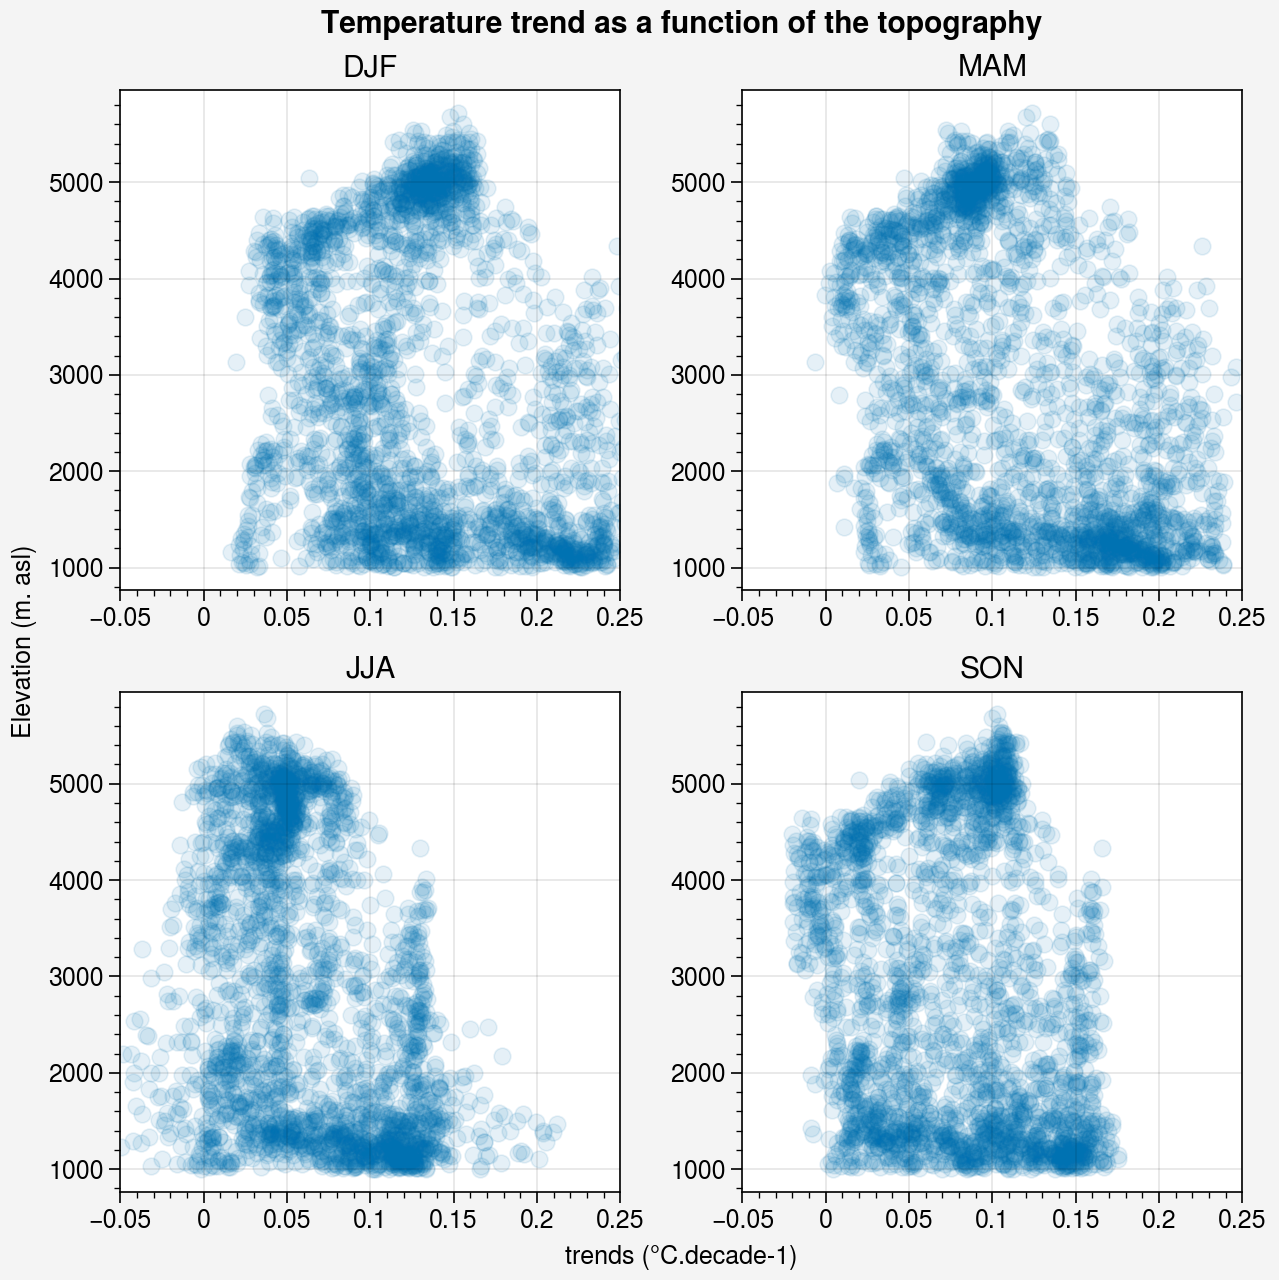

In [39]:
#Plotting trends as a function of elevation
f, axs = plot.subplots(ncols=2, nrows=2,share=1)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.scatter(trends_high[i,:,:].flatten()*factor_trend,topo_high.values.flatten(),alpha=0.1)
    #m = ax.hist2d(topo_high.values.flatten(),trends_high[i,:,:].flatten()*factor_trend,bins=bins,cmap='Spectral_r',levels=levels,cmin=1)
    #m = ax.hist2d(ds_topo_HMA_out.data.values.flatten(),slope_T[i,:,:].flatten()*factor_trend,bins=bins,cmap='Spectral_r',levels=levels,cmin=1)
    #m = ax.scatter(ds_topo_HMA_out.data,slope_T[i,:,:]*factor_trend,alpha=0.1)
    ax.format(title=seasonal_mean.season.data[i],large='15px',xlim=(-0.05,0.25))

    #f.colorbar(m[3],ticks=np.logspace(0,1,2))    

axs.format(
    suptitle='Temperature trend as a function of the topography',
    xlabel='trends (°C.decade-1)',
    ylabel='Elevation (m. asl)',
    large='15px'
)